In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Hello Friends, welcome to my Basic EDA of Impact of Covid on digital learning.

**Importing Libraries 📚**

In [ ]:
import numpy as np 
import pandas as pd 
import math
import glob
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import wandb

import folium
from geopy.geocoders import Nominatim
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster
from wordcloud import WordCloud, STOPWORDS 


***Reading Data***

Product information data
The product file products_info.csv includes information about the characteristics of the top 372 products with most users in 2020. The categories listed in this file are part of LearnPlatform's product taxonomy.

📝 Some products may not have labels due to being duplicate, lack of accurate url or other reasons.

**Name**                     -->        **Description**
* LP ID                      -->        The unique identifier of the product
* URL                        -->        Web Link to the specific product
* Product Name               -->        Name of the specific product
* Provider/Company Name      -->        Name of the product provider
* Sector(s)                  -->        Sector of education where the product is used
* Primary Essential Function -> The basic function of the product. There are two layers of labels here. Products are first labeled as one of these three categories: LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. Each of these categories have multiple sub-categories with which the products were labeled


In [ ]:
products_df = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/products_info.csv")
products_df.head()

**District information data**

The district file districts_info.csv includes information about the characteristics of school districts, including data from

NCES (2018-19),
FCC (Dec 2018), and
Edunomics Lab.
Steps taken to preserve Privacy 🔒

Identifiable information about the school districts has been removed.
An open source tool ARX (Prasser et al. 2020) was used to transform several data fields and reduce the risks of re-identification.
📝 For data generalization purposes some data points are released with a range where the actual value falls under. Additionally, there are many missing data marked as 'NaN' indicating that the data was suppressed to maximize anonymization of the dataset.
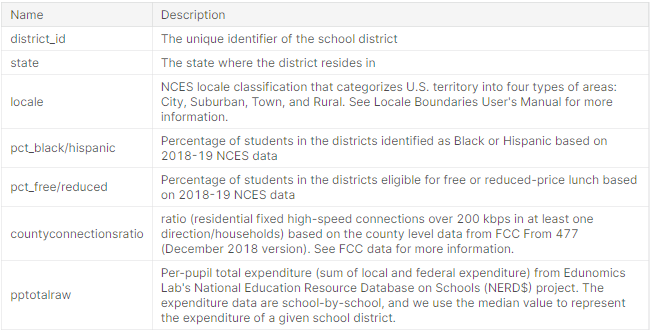

In [ ]:
districts_df = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv")
districts_df.head()

**Engagement Data**

The engagement data are aggregated at school district level, and each file in the folder engagement_data represents data from one school district*.

📝The 4-digit file name represents district_id which can be used to link to district information in district_info.csv.

📝The lp_id can be used to link to product information in product_info.csv

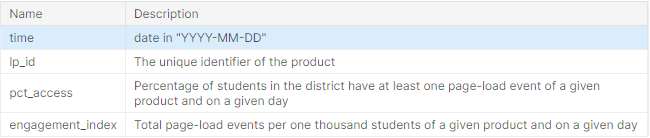

In [ ]:
path = '../input/learnplatform-covid19-impact-on-digital-learning/engagement_data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    district_id = filename.split("/")[4].split(".")[0]
    df["district_id"] = district_id
    li.append(df)
    
engagement_df = pd.concat(li)
engagement_df = engagement_df.reset_index(drop=True)
engagement_df.head()

**Missing values🔮**

In [ ]:
msno.bar(products_df,color='#4895ef', sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

In [ ]:
msno.bar(districts_df,color='#f72585', sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

In [ ]:
msno.bar(engagement_df,color='#FF7F7F', sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

**EDA 📊**

In [ ]:
plt.figure(figsize=(16, 10))
sns.countplot(y="state",data=districts_df,order=districts_df.state.value_counts().index,palette="Blues",linewidth=3)
plt.title("State Distribution",font="Serif", size=20)
plt.show()

In [ ]:
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Locale Distribution', size = 20, font="Serif")
explode = (0.05, 0.05, 0.05, 0.05)
labels = list(districts_df.locale.value_counts().index)
sizes = districts_df.locale.value_counts().values
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.7, colors=["#FFFF33","#ff9100","#eaaa00","#6d6875"])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

In [ ]:
plt.figure(figsize=(16, 10))
sns.countplot(y='Provider/Company Name', data=products_df, order=products_df["Provider/Company Name"].value_counts().index[:10],palette = 'cool')
plt.title("Top 10 Provider/Company Names",font="Serif", size=20)
plt.show()

In [ ]:
c1=c2=c3=0
for s in products_df["Sector(s)"]:
    if(not pd.isnull(s)):
        s = s.split(";")
        for i in range(len(s)):
            sub = s[i].strip()
            if(sub == 'PreK-12'): c1+=1
            if(sub == 'Higher Ed'): c2+=1
            if(sub == 'Corporate'): c3+=1

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Sector Distribution', size = 20, font="Serif")
explode = (0.05, 0.05, 0.05)
labels = ['PreK-12','Higher Ed','Corporate']
sizes = [c1,c2, c3]
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.2f%%', pctdistance=0.7, colors=["#ff228a","#20b1fd","#ffb703"])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

In [ ]:
primary_essential_main = []
primary_essential_sub = []
for s in products_df["Primary Essential Function"]:
    if(not pd.isnull(s)):
        s1 = s.split("-",1)[0].strip()
        primary_essential_main.append(s1)
    else:
        primary_essential_main.append(np.nan)
    
    if(not pd.isnull(s)):
        s2 = s.split("-",1)[1].strip()
        primary_essential_sub.append(s2)
    else:
        primary_essential_sub.append(np.nan)

products_df["primary_essential_main"] = primary_essential_main
products_df["primary_essential_sub"] = primary_essential_sub

In [ ]:
c1=c2=c3=0

for s in products_df["primary_essential_main"]:
    if(not pd.isnull(s)):
        c1 += s.count("CM")
        c2 += s.count("LC")
        c3 += s.count("SDO")

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Primary Essential Function', size = 20, font="Serif")
explode = (0.05, 0.05, 0.05)
labels = ['CM','LC','SDO']
sizes = [c1, c2, c3]
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.2f%%', pctdistance=0.7, colors=["#18ff9f","#2cfbff","#ffb703"])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

In [ ]:
plt.figure(figsize=(16, 20))
sns.countplot(y='primary_essential_sub', data=products_df, order=products_df["primary_essential_sub"].value_counts().index,color = '#d8bbff')
plt.title("Primary Essential Function(Sub)",font="Serif", size=20)
plt.show()

**Merging Data**

In [ ]:
engagement_df['time'] = pd.to_datetime(engagement_df['time'])

In [ ]:
print(products_df["LP ID"].nunique())
print(engagement_df["lp_id"].nunique())

In [ ]:
products_engagement_data = pd.merge(products_df, engagement_df, left_on='LP ID', right_on='lp_id')
products_engagement_data.head()

In [ ]:
print(districts_df["district_id"].nunique())
print(engagement_df["district_id"].nunique())

In [ ]:
engagement_df["district_id"] = engagement_df["district_id"].astype(str).astype(int)
districts_engagement_data = pd.merge(districts_df, engagement_df, left_on='district_id', right_on='district_id')
districts_engagement_data.head()

**Geo Analysis**

In [ ]:
locations=pd.DataFrame({"Name":districts_df['state'].unique()})

In [ ]:
geolocator=Nominatim(user_agent="app")
lat=[]
lon=[]
for location in locations['Name']:
    location = geolocator.geocode(location)    
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)

In [ ]:
locations['lat']=lat
locations['lon']=lon

In [ ]:
Rest_locations=pd.DataFrame(districts_df['state'].value_counts().reset_index())

In [ ]:
Rest_locations.columns=['Name','count']
final_loc=Rest_locations.merge(locations,on='Name',how="left").dropna()
final_loc.head(15).style.set_caption("Locations Dataframe").set_properties(**{'background-color': 'lightgreen',
                           'color': 'darkblue','border': '1.5px solid black'})

In [ ]:
def generateBaseMap(default_location=[37.0902, -95.7129], default_zoom_start=4):
    base_map = folium.Map(location=default_location, zoom_start=default_zoom_start)
    return base_map

In [ ]:
basemap=generateBaseMap()

In [ ]:
HeatMap(final_loc[['lat','lon','count']],zoom=20,radius=20).add_to(basemap)

In [ ]:
basemap

In [ ]:
FastMarkerCluster(data=final_loc[['lat','lon','count']].values.tolist()).add_to(basemap)

basemap

**Basic Wordclouds**

In [ ]:
cloud = WordCloud(width=1440, height=1080,stopwords={'nan'}).generate(" ".join(districts_df['state'].astype(str)))
plt.figure(figsize=(10, 15))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
cloud = WordCloud(width=1440, height=1080,stopwords={'nan'}).generate(" ".join(products_df['Product Name'].astype(str)))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
cloud = WordCloud(width=1440, height=1080,stopwords={'nan'}).generate(" ".join(products_df['Provider/Company Name'].astype(str)))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')

Will update the notebook soon with next version until then take care, upvote if you like the exploration.